# Big Data with H2O - makeup

### 1. import packages

In [100]:
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
import random, os, sys
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
%matplotlib inline

from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

In [101]:
def predictions_test(mod,test):
    '''
    param: 
    mod: model to be used
    test: test dataset
    
    return:
    the prediction
    '''
    mod_perf = mod.model_performance(test)
    predictions = mod.predict(test)    
    
    return predictions, mod_perf

In [102]:
# Function to plot the true/prediction value¶
def plot_result(model, pred_value, y_test):
    plt.figure()
    plt.plot(np.arange(len(pred_value)), y_test,'go-',label='true value')
    plt.plot(np.arange(len(pred_value)),pred_value,'ro-',label='predict value')
    plt.title(model)
    plt.xlabel('Record_index')
    plt.ylabel('Y_xalue')
    plt.legend()
    plt.show()

### 2. Data Overview

In [103]:
rootDir=os.path.abspath(os.curdir)
os.chdir(rootDir)

In [104]:
# load dataset Binary
data_Path_1 = os.path.join(rootDir,'data_folder/cleveland.csv')
heart_disease_1 = pd.read_csv(data_Path_1)
heart_disease_1.columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
                         'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
heart_disease_1.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [105]:
# load dataset Multiclass
data_Path_2 = os.path.join(rootDir,'data_folder/processed.cleveland.data')
heart_disease_2 = pd.read_csv(data_Path_2,header=None)
heart_disease_2.columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
                         'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
heart_disease_2.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [106]:
# load dataset regression
data_Path_3 = os.path.join(rootDir,'data_folder/student-por.csv')
student_por_data=pd.read_csv(data_Path_3)
student_por_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


### 3. Launch H2O cluster

In [107]:
port_no=random.randint(5555,55555)
h2o.init(strict_version_check=False,port=port_no)

Checking whether there is an H2O instance running at http://localhost:49382..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_144"; Java(TM) SE Runtime Environment (build 1.8.0_144-b01); Java HotSpot(TM) 64-Bit Server VM (build 25.144-b01, mixed mode)
  Starting server from /Users/lzq/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/qy/r0h6l3351xl9cvg1kl8ltwmc0000gn/T/tmpzo5nf7sp
  JVM stdout: /var/folders/qy/r0h6l3351xl9cvg1kl8ltwmc0000gn/T/tmpzo5nf7sp/h2o_lzq_started_from_python.out
  JVM stderr: /var/folders/qy/r0h6l3351xl9cvg1kl8ltwmc0000gn/T/tmpzo5nf7sp/h2o_lzq_started_from_python.err
  Server is running at http://127.0.0.1:49382
Connecting to H2O server at http://127.0.0.1:49382... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.7
H2O cluster version age:,2 months and 1 day
H2O cluster name:,H2O_from_python_lzq_uglp3b
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [108]:
# import datasets
df_regression = h2o.import_file(data_Path_3)
df_regression = df_regression.drop('G1', axis=1)
df_regression = df_regression.drop('G2', axis=1)

df_muticlass = h2o.import_file(data_Path_2)
df_muticlass.columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

df_binary = h2o.import_file(data_Path_1)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


### 4. dataset description

In [109]:
# df_regression
categorical_variables = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 
                         'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'schoolsup', 'famsup', 
                         'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 
                         'freetime', 'goout', 'Dalc', 'Walc', 'health']
# convert all categorical_variables into factor
for var in categorical_variables:
    df_regression[var] = df_regression[var].asfactor()
print(df_regression.describe())

Rows:649
Cols:31




,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3
type,enum,enum,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,int,int
mins,,,15.0,,,,,,,,,,,,0.0,,,,,,,,,,,,,,,0.0,0.0
mean,,,16.7442218798151,,,,,,,,,,,,0.2218798151001541,,,,,,,,,,,,,,,3.6594761171032357,11.906009244992296
maxs,,,22.0,,,,,,,,,,,,3.0,,,,,,,,,,,,,,,32.0,19.0
sigma,,,1.2181376394800645,,,,,,,,,,,,0.5932351492649627,,,,,,,,,,,,,,,4.640758808397153,3.2306562428048045
zeros,,,0,,,,,,,,,,,,549,,,,,,,,,,,,,,,244,15
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,GP,F,18.0,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0.0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4.0,11.0
1,GP,F,17.0,U,GT3,T,1,1,at_home,other,course,father,1,2,0.0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2.0,11.0
2,GP,F,15.0,U,LE3,T,1,1,at_home,other,other,mother,1,2,0.0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6.0,12.0


None


In [110]:
# df_muticlass
categorical_variables = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'num']
# convert all categorical_variables into factor
for var in categorical_variables:
    df_muticlass[var] = df_muticlass[var].asfactor()
print(df_muticlass.describe())

Rows:303
Cols:14




,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
type,int,enum,enum,int,int,enum,enum,int,enum,real,enum,int,enum,enum
mins,29.0,,,94.0,126.0,,,71.0,,0.0,,0.0,,
mean,54.43894389438945,,,131.68976897689765,246.69306930693077,,,149.6072607260726,,1.0396039603960403,,0.6722408026755854,,
maxs,77.0,,,200.0,564.0,,,202.0,,6.2,,3.0,,
sigma,9.038662442446752,,,17.59974772958769,51.776917542637065,,,22.875003276980376,,1.161075022068635,,0.937438317724216,,
zeros,0,,,0,0,,,0,,99,,176,,
missing,0,0,0,0,0,0,0,0,0,0,0,4,2,0
0,63.0,1,1,145.0,233.0,1,2,150.0,0,2.3,3,0.0,6,0
1,67.0,1,4,160.0,286.0,0,2,108.0,1,1.5,2,3.0,3,2
2,67.0,1,4,120.0,229.0,0,2,129.0,1,2.6,2,2.0,7,1


None


In [111]:
# df_binary
categorical_variables = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'num']
# convert all categorical_variables into factor
for var in categorical_variables:
    df_binary[var] = df_binary[var].asfactor()
print(df_binary.describe())

Rows:303
Cols:14




,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
type,int,enum,enum,int,int,enum,enum,int,enum,real,enum,int,enum,enum
mins,29.0,,,94.0,126.0,,,71.0,,0.0,,0.0,,
mean,54.43894389438945,,,131.68976897689765,246.69306930693077,,,149.6072607260726,,1.0396039603960403,,0.6722408026755854,,
maxs,77.0,,,200.0,564.0,,,202.0,,6.2,,3.0,,
sigma,9.038662442446752,,,17.59974772958769,51.776917542637065,,,22.875003276980376,,1.161075022068635,,0.937438317724216,,
zeros,0,,,0,0,,,0,,99,,176,,
missing,0,0,0,0,0,0,0,0,0,0,0,4,2,0
0,63.0,1,1,145.0,233.0,1,2,150.0,0,2.3,3,0.0,6,0
1,67.0,1,4,160.0,286.0,0,2,108.0,1,1.5,2,3.0,3,1
2,67.0,1,4,120.0,229.0,0,2,129.0,1,2.6,2,2.0,7,1


None


### 5. Regression

In [112]:
# Split data into train/test by 0.9
train_1, test_1 = df_regression.split_frame([0.9])

In [113]:
# specify x/y variable
y = df_regression.columns[-1]
print(y)

X = []
for i in df_regression.columns:
    if i not in y:
        X.append(i)
print(X)

G3
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


##### GBM model

In [114]:
gbm_model = H2OGradientBoostingEstimator(model_id = 'gbm_model',
                                         score_tree_interval = 10, ntrees = 500,
                                         stopping_rounds = 10, stopping_tolerance = 0.001)
gbm_model.train(x = X, y = y, training_frame = train_1, validation_frame = test_1)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [115]:
gbm_model.model_performance()


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.15705484148096405
RMSE: 0.39630145278684514
MAE: 0.2793395859181371
RMSLE: 0.08731077814987462
Mean Residual Deviance: 0.15705484148096405


In [116]:
gbm_model.model_performance(test_1)


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 10.11091459331795
RMSE: 3.17976643691293
MAE: 2.4533453528534426
RMSLE: 0.38676928681843553
Mean Residual Deviance: 10.11091459331795


In [117]:
gbm_model.varimp()

[('failures', 6329.70068359375, 1.0, 0.2024769387269545),
 ('absences', 2128.91162109375, 0.33633685501303034, 0.06810045678408991),
 ('Walc', 1975.2034912109375, 0.31205322177880557, 0.06318358106565594),
 ('health', 1752.461181640625, 0.27686319926357844, 0.056058413033040155),
 ('school', 1547.1068115234375, 0.24442021650936144, 0.04948945720179492),
 ('goout', 1413.53076171875, 0.22331715706282085, 0.04521657432728645),
 ('higher', 1359.67041015625, 0.21480801038198283, 0.04349366835617174),
 ('Dalc', 1331.1016845703125, 0.210294570171455, 0.04257980079921692),
 ('reason', 1328.98974609375, 0.2099609148246806, 0.042512243286012164),
 ('Fedu', 1317.088623046875, 0.20808071169316097, 0.04213154551175723),
 ('freetime', 1263.646240234375, 0.19963759795304056, 0.04042200968833416),
 ('Mjob', 1138.288818359375, 0.1798329613451959, 0.03641202749537801),
 ('studytime', 1077.2867431640625, 0.17019552693168144, 0.034460669278147796),
 ('famrel', 1074.48583984375, 0.16975302523052324, 0.0343

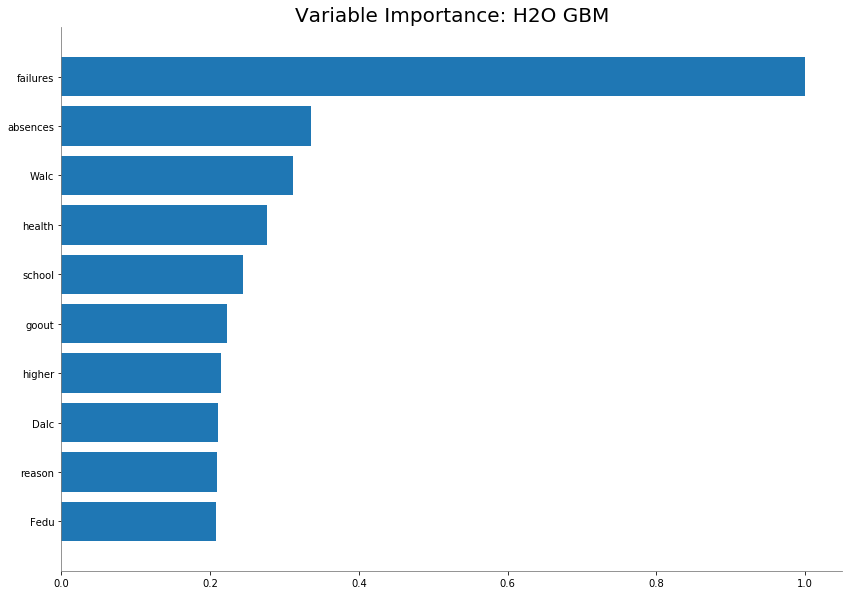

In [118]:
gbm_model.varimp_plot()

In [119]:
gbm_model.scoring_history()

,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2018-11-02 11:57:39,0.036 sec,0.0,3.210967,2.388359,10.310310,3.387323,2.612527,11.473958
1,,2018-11-02 11:57:39,0.515 sec,10.0,2.424533,1.774836,5.878362,3.129290,2.364204,9.792456
2,,2018-11-02 11:57:40,0.697 sec,20.0,2.074583,1.542703,4.303893,3.129860,2.345901,9.796022
3,,2018-11-02 11:57:40,0.898 sec,30.0,1.778911,1.337847,3.164524,3.166076,2.404508,10.024034
4,,2018-11-02 11:57:40,1.060 sec,40.0,1.566297,1.185972,2.453286,3.185836,2.445896,10.149553
5,,2018-11-02 11:57:40,1.141 sec,50.0,1.387710,1.047135,1.925738,3.210652,2.506107,10.308284
6,,2018-11-02 11:57:40,1.213 sec,60.0,1.284606,0.962090,1.650213,3.230339,2.517655,10.435090
7,,2018-11-02 11:57:40,1.266 sec,70.0,1.180337,0.878559,1.393195,3.221248,2.513933,10.376438
8,,2018-11-02 11:57:40,1.329 sec,80.0,1.073962,0.795744,1.153394,3.212928,2.511275,10.322905
9,,2018-11-02 11:57:40,1.387 sec,90.0,0.975866,0.716656,0.952314,3.227656,2.525897,10.417764


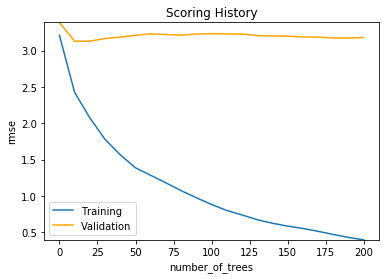

In [120]:
gbm_model.plot()

In [125]:
predictions_df, mod_perf = predictions_test(gbm_model,test_1)
predictions_df.head(5)

gbm prediction progress: |████████████████████████████████████████████████| 100%


predict
11.5956
12.7912
13.6452
12.9963
12.517


In [126]:
actual_value = [test_1[x, 'G3'] for x in range(len(test_1['G3']))]

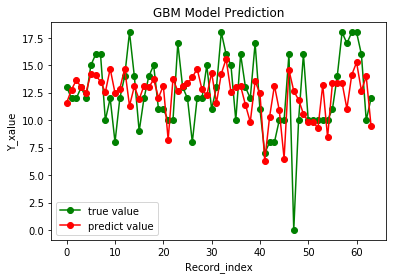

In [127]:
pred_value = [predictions_df[x,0] for x in range(len(predictions_df[0]))]
plot_result('GBM Model Prediction', pred_value, actual_value)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%
PartialDependence: Partial Dependence Plot of model gbm_model on column 'Walc'



walc,mean_response,stddev_response,std_error_mean_response
1,11.9217058,2.7802301,0.1149484
2,12.0152784,2.7113143,0.1120990
3,11.6688500,2.9880184,0.1235394
4,11.6929734,2.8248145,0.1167917
5,11.8215696,2.8681402,0.1185830


[]

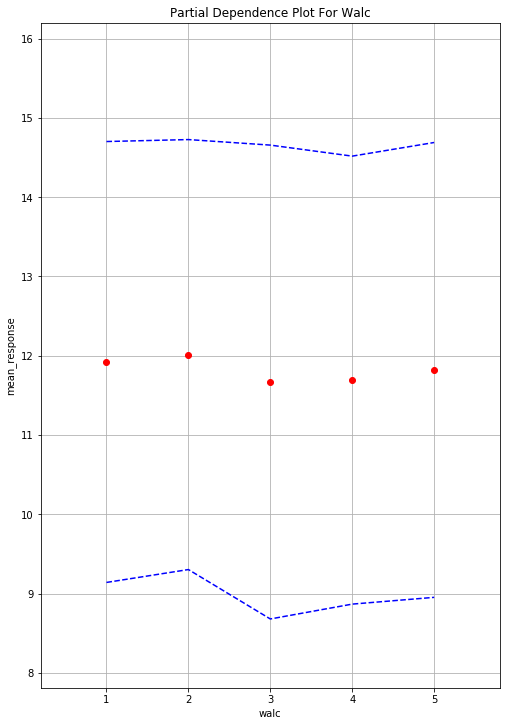

In [132]:
gbm_model.partial_plot(train_1, ['Walc'])

#### GLM Model

In [25]:
glm_model = H2OGeneralizedLinearEstimator(model_id = 'glm_model')
                                          #nfolds=10,  
                                          #max_iterations=2000)
glm_model.train(x = X, y = y, training_frame = train_1, validation_frame = test_1)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [26]:
glm_model.model_performance()


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 7.560931228184977
RMSE: 2.749714753967214
MAE: 2.015273903311765
RMSLE: 0.39392642510070003
R^2: 0.23903812701805072
Mean Residual Deviance: 7.560931228184977
Null degrees of freedom: 585
Residual degrees of freedom: 566
Null deviance: 5822.506825938566
Residual deviance: 4430.705699716396
AIC: 2890.470656424935


In [27]:
glm_model.model_performance(test_1)


ModelMetricsRegressionGLM: glm
** Reported on test data. **

MSE: 10.891697726406838
RMSE: 3.300257221249101
MAE: 2.287089930154782
RMSLE: 0.5660524053053161
R^2: 0.2503009212981041
Mean Residual Deviance: 10.891697726406838
Null degrees of freedom: 62
Residual degrees of freedom: 43
Null deviance: 943.5001193956831
Residual deviance: 686.1769567636308
AIC: 371.23030700354127


In [28]:
glm_model.scoring_history()

,,timestamp,duration,iterations,negative_log_likelihood,objective
0,,2018-11-02 11:55:59,0.000 sec,0,5822.506826,9.936018


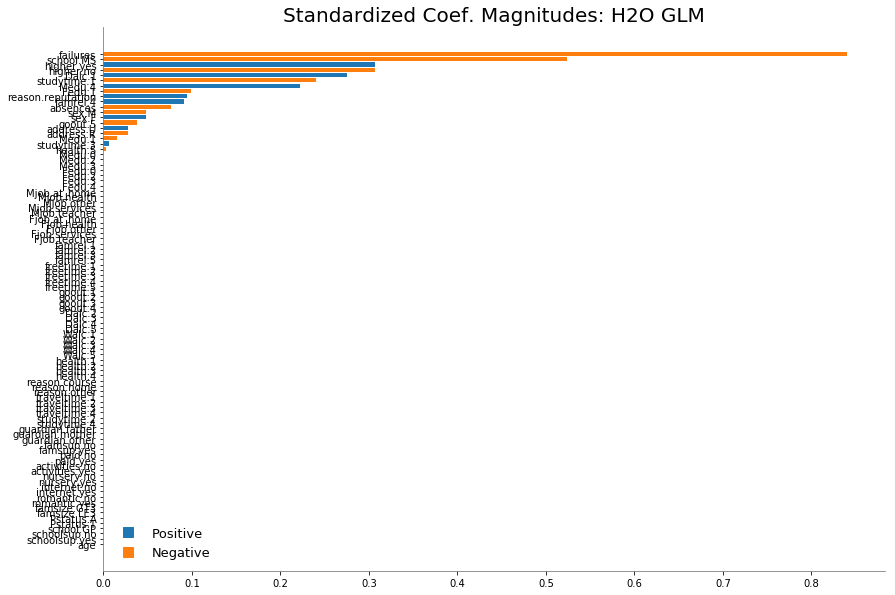

In [29]:
glm_model.std_coef_plot()

In [30]:
predictions_df, mod_perf = predictions_test(glm_model,test_1)
predictions_df.head(5)

glm prediction progress: |████████████████████████████████████████████████| 100%


predict
12.7892
7.3804
12.5694
12.8338
12.9148


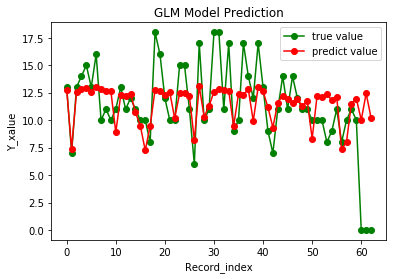

In [31]:
pred_value = [predictions_df[x,0] for x in range(len(predictions_df[0]))]
plot_result('GLM Model Prediction', pred_value, actual_value)

#### Neural Network model

In [32]:
nn_model = H2ODeepLearningEstimator(model_id='nn_model',
                                    activation='rectifier_with_dropout',
                                    adaptive_rate=True,
                                    epochs=50,
                                    hidden=[100, 100])
nn_model.train(x = X, y = y, training_frame = train_1, validation_frame = test_1)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [33]:
nn_model.model_performance()


ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 4.0995300843575775
RMSE: 2.0247296324096156
MAE: 1.5329596361647813
RMSLE: 0.30554974054789663
Mean Residual Deviance: 4.0995300843575775


In [34]:
nn_model.model_performance(test_1)


ModelMetricsRegression: deeplearning
** Reported on test data. **

MSE: 10.015914614932324
RMSE: 3.164792981370555
MAE: 2.384907230223261
RMSLE: 0.5262843474052205
Mean Residual Deviance: 10.015914614932324


In [35]:
nn_model.scoring_history()

,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
0,,2018-11-02 11:56:05,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2018-11-02 11:56:06,0.922 sec,4549 obs/sec,5.0,1,2930.0,2.733292,7.470883,2.015702,0.248101,3.177037,10.093562,2.271452,0.305238
2,,2018-11-02 11:56:08,2.616 sec,12717 obs/sec,50.0,10,29300.0,2.024730,4.099530,1.532960,0.587407,3.164793,10.015915,2.384907,0.310583


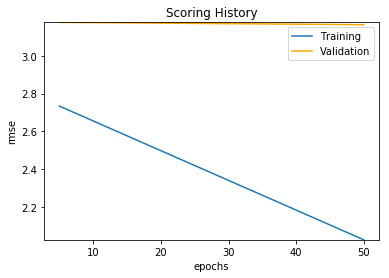

In [36]:
nn_model.plot()

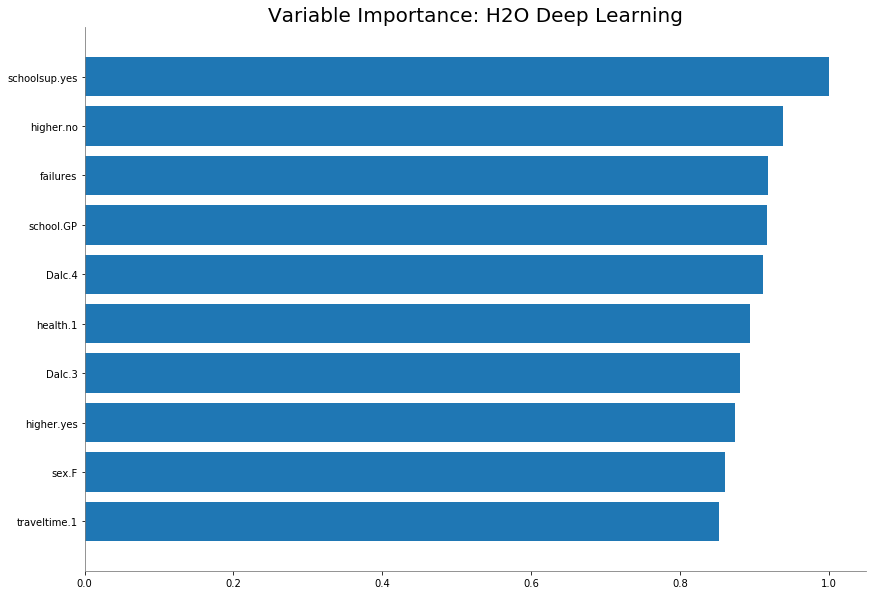

In [37]:
nn_model.varimp_plot()

In [38]:
predictions_df, mod_perf = predictions_test(nn_model,test_1)
predictions_df.head(5)

deeplearning prediction progress: |███████████████████████████████████████| 100%


predict
13.7406
6.13995
11.4357
12.7683
13.059


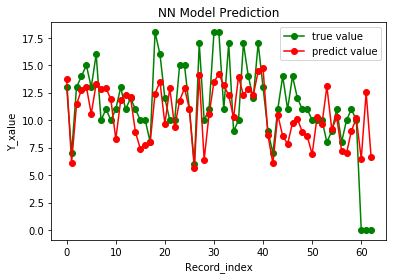

In [39]:
pred_value = [predictions_df[x,0] for x in range(len(predictions_df[0]))]
plot_result('NN Model Prediction', pred_value, actual_value)

### 6. MultiClass

In [182]:
# Split data into train/test by 0.9
train_2, test_2 = df_muticlass.split_frame([0.9])

In [183]:
# specify x/y variable
y = df_muticlass.columns[-1]
print(y)

X = []
for i in df_muticlass.columns:
    if i not in y:
        X.append(i)
print(X)

num
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


##### GBM Model

In [184]:
gbm_model = H2OGradientBoostingEstimator(model_id = 'gbm_model',
                                         score_tree_interval = 10, ntrees = 500,
                                         stopping_rounds = 10, stopping_tolerance = 0.001)
gbm_model.train(x = X, y = y, training_frame = train_2, validation_frame = test_2)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [185]:
gbm_model.model_performance()


ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 3.944394519607316e-07
RMSE: 0.000628044148098469
LogLoss: 0.0004596888514506944
Mean Per-Class Error: 0.0
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



0,1,2,3,4,Error,Rate
148.0,0.0,0.0,0.0,0.0,0.0,0 / 148
0.0,51.0,0.0,0.0,0.0,0.0,0 / 51
0.0,0.0,35.0,0.0,0.0,0.0,0 / 35
0.0,0.0,0.0,32.0,0.0,0.0,0 / 32
0.0,0.0,0.0,0.0,12.0,0.0,0 / 12
148.0,51.0,35.0,32.0,12.0,0.0,0 / 278


Top-5 Hit Ratios: 


k,hit_ratio
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0


In [186]:
gbm_model.model_performance(test_2)


ModelMetricsMultinomial: gbm
** Reported on test data. **

MSE: 0.5261287146003505
RMSE: 0.7253473061922479
LogLoss: 3.6079444582120055
Mean Per-Class Error: 0.8625
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



0,1,2,3,4,Error,Rate
11.0,2.0,1.0,1.0,1.0,0.3125,5 / 16
2.0,0.0,0.0,2.0,0.0,1.0,4 / 4
1.0,0.0,0.0,0.0,0.0,1.0,1 / 1
0.0,1.0,0.0,0.0,2.0,1.0,3 / 3
0.0,1.0,0.0,0.0,0.0,1.0,1 / 1
14.0,4.0,1.0,3.0,3.0,0.56,14 / 25


Top-5 Hit Ratios: 


k,hit_ratio
1,0.44
2,0.6
3,0.88
4,1.0
5,1.0


In [187]:
gbm_model.varimp()

[('oldpeak', 92.14957427978516, 1.0, 0.15134789320056716),
 ('cp', 89.76896667480469, 0.9741658317622559, 0.14743794626519557),
 ('thalach', 75.10028839111328, 0.8149824779775247, 0.12334588103727598),
 ('thal', 71.34207153320312, 0.7741986014671521, 0.11717332725087899),
 ('ca', 65.67285919189453, 0.7126767508713405, 0.10786212477740284),
 ('age', 61.12113571166992, 0.663281802323834, 0.10038630337998733),
 ('chol', 54.801509857177734, 0.5947017149616886, 0.09000685164221577),
 ('trestbps', 26.508481979370117, 0.28766798095979135, 0.04353794285952529),
 ('exang', 25.354909896850586, 0.2751495066039897, 0.04164329813968938),
 ('sex', 13.840510368347168, 0.15019614009636678, 0.022731869370442342),
 ('slope', 13.220420837402344, 0.14346697682251264, 0.021713424685941885),
 ('fbs', 11.114540100097656, 0.12061412314669642, 0.018254693428486266),
 ('restecg', 8.864044189453125, 0.09619191687788002, 0.01455844396239122)]

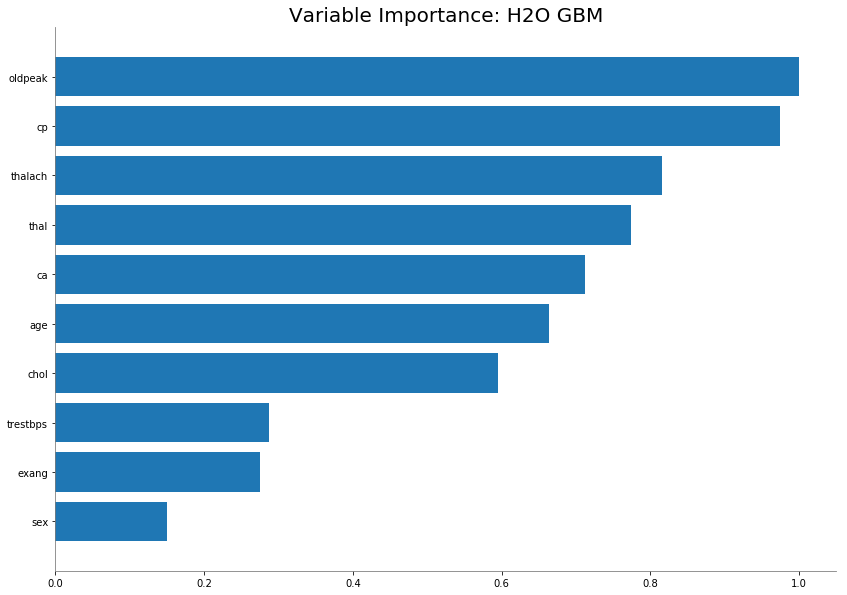

In [188]:
gbm_model.varimp_plot()

In [189]:
gbm_model.scoring_history().head(5)

,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,validation_rmse,validation_logloss,validation_classification_error
0,,2018-11-02 12:36:10,0.001 sec,0.0,0.800000,1.609438,0.647482,0.800000,1.609438,0.48
1,,2018-11-02 12:36:10,0.238 sec,10.0,0.496498,0.687579,0.129496,0.664806,1.227409,0.48
2,,2018-11-02 12:36:10,0.371 sec,20.0,0.364727,0.418001,0.071942,0.664555,1.359392,0.48
3,,2018-11-02 12:36:10,0.480 sec,30.0,0.263290,0.261312,0.017986,0.674893,1.505694,0.48
4,,2018-11-02 12:36:10,0.611 sec,40.0,0.192264,0.173686,0.007194,0.686278,1.673288,0.48


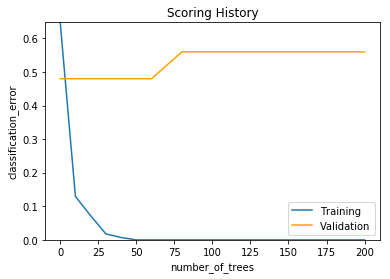

In [190]:
gbm_model.plot()

In [191]:
predictions_df, mod_perf = predictions_test(gbm_model,test_2)
predictions_df.head(5)

gbm prediction progress: |████████████████████████████████████████████████| 100%


predict,p0,p1,p2,p3,p4
3,0.00022008,0.000638148,0.128738,0.840326,0.0300772
1,4.00921e-05,0.963467,0.0128873,0.0231045,0.000500891
0,0.994314,0.0053827,0.000260359,4.32938e-05,1.16056e-07
0,0.943661,0.0559242,9.33385e-05,0.00028551,3.55162e-05
0,0.999985,1.51325e-05,3.23253e-08,6.01771e-08,6.66665e-09


In [192]:
actual_value = [test_2[x, 'num'] for x in range(len(test_2['num']))]

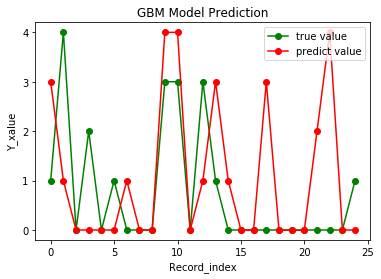

In [193]:
pred_value = [predictions_df[x,0] for x in range(len(predictions_df[0]))]
plot_result('GBM Model Prediction', pred_value, actual_value)

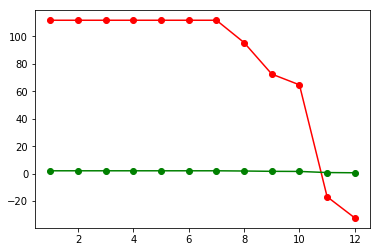

In [197]:
gain_table = drf_model.gains_lift().as_data_frame()

plt.figure()
plt.plot(gain_table['group'][:12],gain_table['gain'][:12],'ro-',label='Gain')
plt.plot(gain_table['group'][:12],gain_table['lift'][:12],'go-',label='Lift')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [198]:
gain_table

,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.011152,0.999589,2.118110,2.118110,1.000000,1.000000,1.000000,1.000000,0.023622,0.023622,111.811024,111.811024
1,,2,0.022305,0.999290,2.118110,2.118110,1.000000,0.999357,1.000000,0.999678,0.023622,0.047244,111.811024,111.811024
2,,3,0.033457,0.986835,2.118110,2.118110,1.000000,0.991241,1.000000,0.996866,0.023622,0.070866,111.811024,111.811024
3,,4,0.040892,0.985618,2.118110,2.118110,1.000000,0.986190,1.000000,0.994925,0.015748,0.086614,111.811024,111.811024
4,,5,0.052045,0.984122,2.118110,2.118110,1.000000,0.985083,1.000000,0.992816,0.023622,0.110236,111.811024,111.811024
5,,6,0.100372,0.951452,2.118110,2.118110,1.000000,0.966363,1.000000,0.980079,0.102362,0.212598,111.811024,111.811024
6,,7,0.152416,0.909081,2.118110,2.118110,1.000000,0.923760,1.000000,0.960849,0.110236,0.322835,111.811024,111.811024
7,,8,0.200743,0.872063,1.955179,2.078886,0.923077,0.884936,0.981481,0.942573,0.094488,0.417323,95.517868,107.888597
8,,9,0.301115,0.754839,1.725868,1.961213,0.814815,0.814831,0.925926,0.899992,0.173228,0.590551,72.586760,96.121318
9,,10,0.401487,0.576678,1.647419,1.882765,0.777778,0.654199,0.888889,0.838544,0.165354,0.755906,64.741907,88.276465


##### DRF Model

In [52]:
drf_model = H2ORandomForestEstimator(model_id = 'rf_model', max_depth=50, ntrees=200)
drf_model.train(x = X, y = y, training_frame = train_2, validation_frame = test_2)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [53]:
drf_model.model_performance()


ModelMetricsMultinomial: drf
** Reported on train data. **

MSE: 0.35690965574907085
RMSE: 0.597419162522488
LogLoss: 1.1302330626657835
Mean Per-Class Error: 0.7241363532372456
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



0,1,2,3,4,Error,Rate
134.0,3.0,2.0,2.0,0.0,0.0496454,7 / 141
27.0,5.0,8.0,7.0,0.0,0.8936170,42 / 47
10.0,8.0,3.0,10.0,0.0,0.9032258,28 / 31
5.0,10.0,6.0,7.0,3.0,0.7741935,24 / 31
3.0,5.0,0.0,4.0,0.0,1.0,12 / 12
179.0,31.0,19.0,30.0,3.0,0.4312977,113 / 262


Top-5 Hit Ratios: 


k,hit_ratio
1,0.5687023
2,0.7671756
3,0.870229
4,0.9580153
5,1.0


In [54]:
drf_model.model_performance(test_2)


ModelMetricsMultinomial: drf
** Reported on test data. **

MSE: 0.3337378825785735
RMSE: 0.5777005128771945
LogLoss: 0.9197383356984066
Mean Per-Class Error: 0.663695652173913
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



0,1,2,3,4,Error,Rate
22.0,1.0,0.0,0.0,0.0,0.0434783,1 / 23
6.0,1.0,0.0,1.0,0.0,0.875,7 / 8
1.0,0.0,3.0,1.0,0.0,0.4,2 / 5
1.0,1.0,2.0,0.0,0.0,1.0,4 / 4
0.0,1.0,0.0,0.0,0.0,1.0,1 / 1
30.0,4.0,5.0,2.0,0.0,0.3658537,15 / 41


Top-5 Hit Ratios: 


k,hit_ratio
1,0.6341463
2,0.8048781
3,0.902439
4,1.0
5,1.0


In [55]:
drf_model.varimp()

[('thalach', 2801.906982421875, 1.0, 0.12423520521956233),
 ('oldpeak', 2779.300048828125, 0.991931590257786, 0.12323282467944287),
 ('thal', 2494.111083984375, 0.8901477099816313, 0.11058768342529142),
 ('ca', 2479.312744140625, 0.8848661856710138, 0.10993153216868976),
 ('chol', 2276.975830078125, 0.8126521845168404, 0.1009600109155753),
 ('age', 2237.994873046875, 0.7987398893279558, 0.09923161406770908),
 ('trestbps', 2137.651123046875, 0.7629272265131231, 0.09478242055344936),
 ('cp', 1942.9483642578125, 0.6934378537357413, 0.08614939406587267),
 ('exang', 873.080810546875, 0.3116023536913467, 0.0387119823577431),
 ('slope', 847.94189453125, 0.3026302799667951, 0.03759733493732839),
 ('sex', 686.0343017578125, 0.24484549489391946, 0.030418430305231385),
 ('restecg', 644.7800903320312, 0.23012187570006512, 0.028589238453108203),
 ('fbs', 351.20654296875, 0.12534553972422696, 0.015572328850996138)]

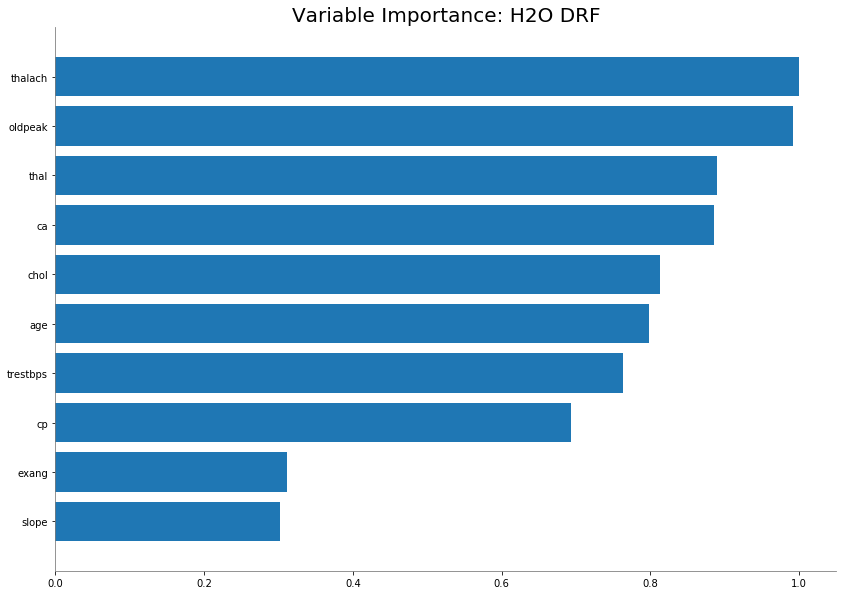

In [56]:
drf_model.varimp_plot()

In [57]:
drf_model.scoring_history().head(5)

,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,validation_rmse,validation_logloss,validation_classification_error
0,,2018-11-02 11:56:19,0.003 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2018-11-02 11:56:19,0.052 sec,1.0,0.738416,17.884398,0.484536,0.736670,17.775123,0.463415
2,,2018-11-02 11:56:19,0.069 sec,2.0,0.710107,15.576560,0.490566,0.675129,13.674430,0.463415
3,,2018-11-02 11:56:19,0.090 sec,3.0,0.704702,15.188300,0.485000,0.633403,10.415907,0.341463
4,,2018-11-02 11:56:19,0.103 sec,4.0,0.683013,14.021564,0.466960,0.617208,8.804023,0.390244


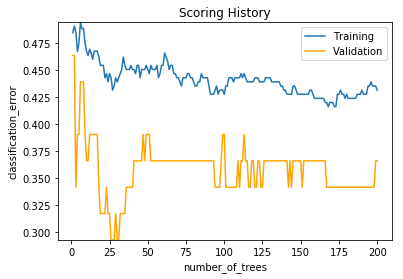

In [58]:
drf_model.plot()

In [59]:
predictions_df, mod_perf = predictions_test(drf_model,test_2)
predictions_df.head(5)

drf prediction progress: |████████████████████████████████████████████████| 100%


predict,p0,p1,p2,p3,p4
0,0.465458,0.071192,0.14925,0.22261,0.0914895
0,0.740766,0.210702,0.0333732,0.00953521,0.00562347
0,0.884236,0.0847401,0.025071,0.00501421,0.000938384
0,0.737508,0.240042,0.0148991,0.00662184,0.000929434
0,0.830485,0.130361,0.0237886,0.00951542,0.00584969


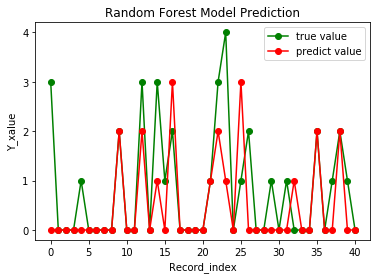

In [60]:
pred_value = [predictions_df[x,0] for x in range(len(predictions_df[0]))]
plot_result('Random Forest Model Prediction', pred_value, actual_value)

##### Neural Networks Model

In [61]:
nn_model = H2ODeepLearningEstimator(model_id='nn_model',
                                    activation='rectifier_with_dropout',
                                    adaptive_rate=True,
                                    epochs=50,
                                    hidden=[100, 100])
nn_model.train(x = X, y = y, training_frame = train_2, validation_frame = test_2)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [62]:
nn_model.model_performance()


ModelMetricsMultinomial: deeplearning
** Reported on train data. **

MSE: 0.2909612853957871
RMSE: 0.5394082733846294
LogLoss: 0.7877657113585901
Mean Per-Class Error: 0.5840196751315487
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



0,1,2,3,4,Error,Rate
138.0,2.0,1.0,0.0,0.0,0.0212766,3 / 141
28.0,16.0,0.0,3.0,0.0,0.6595745,31 / 47
12.0,6.0,8.0,4.0,1.0,0.7419355,23 / 31
2.0,11.0,2.0,13.0,3.0,0.5806452,18 / 31
3.0,4.0,1.0,3.0,1.0,0.9166667,11 / 12
183.0,39.0,12.0,23.0,5.0,0.3282443,86 / 262


Top-5 Hit Ratios: 


k,hit_ratio
1,0.6717557
2,0.851145
3,0.9389313
4,0.9961832
5,1.0


In [63]:
nn_model.model_performance(test_2)


ModelMetricsMultinomial: deeplearning
** Reported on test data. **

MSE: 0.2937782155389276
RMSE: 0.5420131138071547
LogLoss: 0.8021200777757852
Mean Per-Class Error: 0.678695652173913
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



0,1,2,3,4,Error,Rate
22.0,1.0,0.0,0.0,0.0,0.0434783,1 / 23
5.0,2.0,0.0,1.0,0.0,0.75,6 / 8
1.0,2.0,2.0,0.0,0.0,0.6,3 / 5
1.0,3.0,0.0,0.0,0.0,1.0,4 / 4
0.0,1.0,0.0,0.0,0.0,1.0,1 / 1
29.0,9.0,2.0,1.0,0.0,0.3658537,15 / 41


Top-5 Hit Ratios: 


k,hit_ratio
1,0.6341463
2,0.8292683
3,0.902439
4,0.9756097
5,0.9999999


In [64]:
nn_model.varimp()

[('ca', 1.0, 1.0, 0.04655542530175509),
 ('thal.3', 0.97169429063797, 0.97169429063797, 0.04523764096393791),
 ('thal.7', 0.9360331296920776, 0.9360331296920776, 0.04357742044934756),
 ('cp.4', 0.9050648808479309, 0.9050648808479309, 0.04213568045355772),
 ('sex.0', 0.8762304186820984, 0.8762304186820984, 0.04079327980408002),
 ('sex.1', 0.8696452975273132, 0.8696452975273132, 0.040486706688055416),
 ('thal.6', 0.8624526858329773, 0.8624526858329773, 0.040151851591595226),
 ('restecg.2', 0.8480496406555176, 0.8480496406555176, 0.039481311697718194),
 ('oldpeak', 0.8428974747657776, 0.8428974747657776, 0.03924145042349616),
 ('cp.2', 0.831139087677002, 0.831139087677002, 0.03869403371171554),
 ('cp.1', 0.8202472925186157, 0.8202472925186157, 0.03818696155581727),
 ('slope.2', 0.8196461796760559, 0.8196461796760559, 0.03815897649177755),
 ('cp.3', 0.817033588886261, 0.817033588886261, 0.0380373462164192),
 ('slope.3', 0.8138830661773682, 0.8138830661773682, 0.03789067229178386),
 ('age',

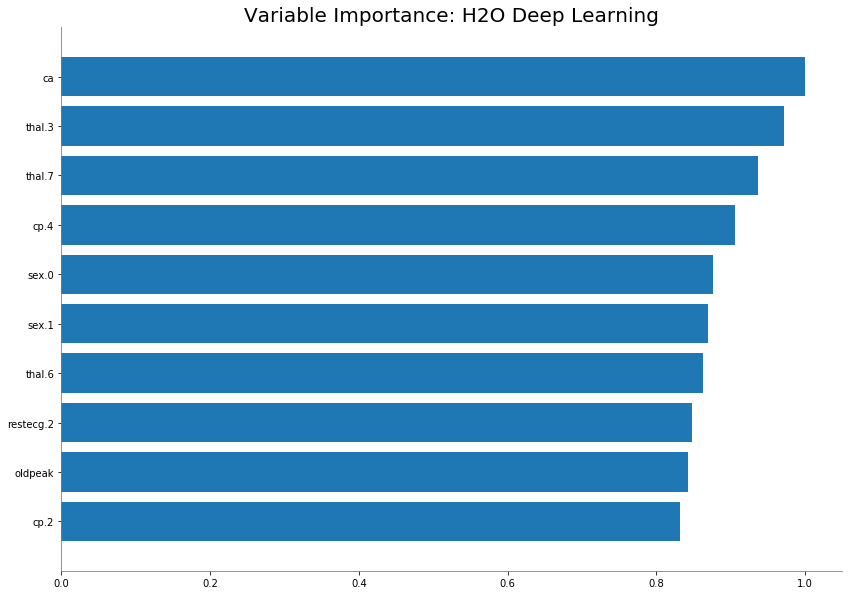

In [65]:
nn_model.varimp_plot()

In [66]:
nn_model.scoring_history()

,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_classification_error
0,,2018-11-02 11:56:26,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2018-11-02 11:56:26,0.100 sec,23818 obs/sec,5.0,1,1310.0,0.597406,1.324893,0.768233,0.408397,0.603330,1.272951,0.711913,0.414634
2,,2018-11-02 11:56:27,0.529 sec,27521 obs/sec,50.0,10,13100.0,0.539408,0.787766,0.811050,0.328244,0.542013,0.802120,0.767495,0.365854


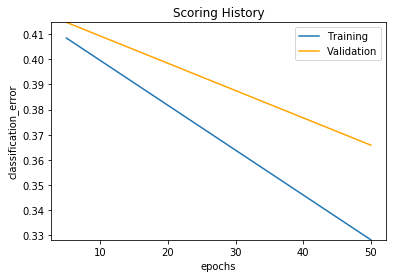

In [67]:
nn_model.plot()

In [68]:
predictions_df, mod_perf = predictions_test(nn_model,test_2)
predictions_df.head(5)

deeplearning prediction progress: |███████████████████████████████████████| 100%


predict,p0,p1,p2,p3,p4
0,0.375926,0.226821,0.133073,0.0910941,0.173086
0,0.896027,0.0994955,0.0025127,0.000712898,0.00125212
0,0.806981,0.172763,0.0146713,0.0017081,0.00387667
0,0.973118,0.0256092,0.000842931,0.000240686,0.00018917
0,0.915671,0.0801843,0.00352852,0.000221031,0.000394815


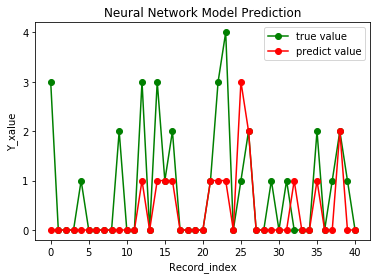

In [69]:
pred_value = [predictions_df[x,0] for x in range(len(predictions_df[0]))]
plot_result('Neural Network Model Prediction', pred_value, actual_value)

### 7. BinaryClass

In [133]:
# Split data into train/test by 0.9
train_3, test_3 = df_binary.split_frame([0.9])

In [134]:
# specify x/y variable
y = df_binary.columns[-1]
print(y)

X = []
for i in df_binary.columns:
    if i not in y:
        X.append(i)
print(X)

num
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


##### GBM Model

In [135]:
gbm_model = H2OGradientBoostingEstimator(model_id = 'gbm_model',
                                         score_tree_interval = 10, ntrees = 500,
                                         stopping_rounds = 10, stopping_tolerance = 0.001)
gbm_model.train(x = X, y = y, training_frame = train_3, validation_frame = test_3)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [136]:
gbm_model.model_performance(test_3)


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.14663884721059256
RMSE: 0.38293452078729145
LogLoss: 1.1378665677146973
Mean Per-Class Error: 0.17045454545454541
AUC: 0.8030303030303031
Gini: 0.6060606060606062
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4602925697705245: 


,0,1,Error,Rate
0,20.0,2.0,0.0909,(2.0/22.0)
1,3.0,9.0,0.25,(3.0/12.0)
Total,23.0,11.0,0.1471,(5.0/34.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4602926,0.7826087,10.0
max f2,0.0000378,0.7692308,29.0
max f0point5,0.4602926,0.8035714,10.0
max accuracy,0.4602926,0.8529412,10.0
max precision,0.9999962,1.0,0.0
max recall,0.0000378,1.0,29.0
max specificity,0.9999962,1.0,0.0
max absolute_mcc,0.4602926,0.6732665,10.0
max min_per_class_accuracy,0.4602926,0.75,10.0
max mean_per_class_accuracy,0.4602926,0.8295455,10.0


Gains/Lift Table: Avg response rate: 35.29 %, avg score: 29.12 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0294118,0.9999957,2.8333333,2.8333333,1.0,0.9999962,1.0,0.9999962,0.0833333,0.0833333,183.3333333,183.3333333
,2,0.0294118,0.9999953,0.0,2.8333333,0.0,0.0,1.0,0.9999962,0.0,0.0833333,-100.0,183.3333333
,3,0.0294118,0.9999948,0.0,2.8333333,0.0,0.0,1.0,0.9999962,0.0,0.0833333,-100.0,183.3333333
,4,0.0588235,0.9999731,0.0,1.4166667,0.0,0.9999948,0.5,0.9999955,0.0,0.0833333,-100.0,41.6666667
,5,0.0588235,0.9999508,0.0,1.4166667,0.0,0.0,0.5,0.9999955,0.0,0.0833333,-100.0,41.6666667
,6,0.1176471,0.9998695,2.8333333,2.125,1.0,0.9999167,0.75,0.9999561,0.1666667,0.25,183.3333333,112.5
,7,0.1470588,0.9849371,2.8333333,2.2666667,1.0,0.9997833,0.8,0.9999215,0.0833333,0.3333333,183.3333333,126.6666667
,8,0.2058824,0.9064932,2.8333333,2.4285714,1.0,0.9609079,0.8571429,0.9887748,0.1666667,0.5,183.3333333,142.8571429
,9,0.2941176,0.4650103,1.8888889,2.2666667,0.6666667,0.6626589,0.8,0.8909400,0.1666667,0.6666667,88.8888889,126.6666667
,10,0.4117647,0.0556249,0.7083333,1.8214286,0.25,0.2310264,0.6428571,0.7023933,0.0833333,0.75,-29.1666667,82.1428571


In [137]:
gbm_model.varimp()

[('cp', 89.34912872314453, 1.0, 0.2770620786784406),
 ('ca', 60.51640701293945, 0.6773027099173448, 0.18765489670424043),
 ('thal', 44.175537109375, 0.494414861573597, 0.13698360927709427),
 ('oldpeak', 26.36130714416504, 0.29503709236883185, 0.08174359009895164),
 ('slope', 22.124494552612305, 0.24761847002634835, 0.06860568802467522),
 ('age', 21.248050689697266, 0.2378092656676716, 0.06588792947487862),
 ('chol', 15.889387130737305, 0.17783483015231016, 0.04927128770342649),
 ('sex', 13.094200134277344, 0.14655095490467263, 0.04060371219819901),
 ('thalach', 9.010533332824707, 0.1008463480460405, 0.02794069881676548),
 ('trestbps', 8.353530883789062, 0.09349314316956744, 0.02590340458874141),
 ('exang', 7.000778675079346, 0.07835307154221752, 0.02170866487232736),
 ('restecg', 4.459781169891357, 0.049914098028984125, 0.0138293037552698),
 ('fbs', 0.904621958732605, 0.010124575042423178, 0.002805135806989627)]

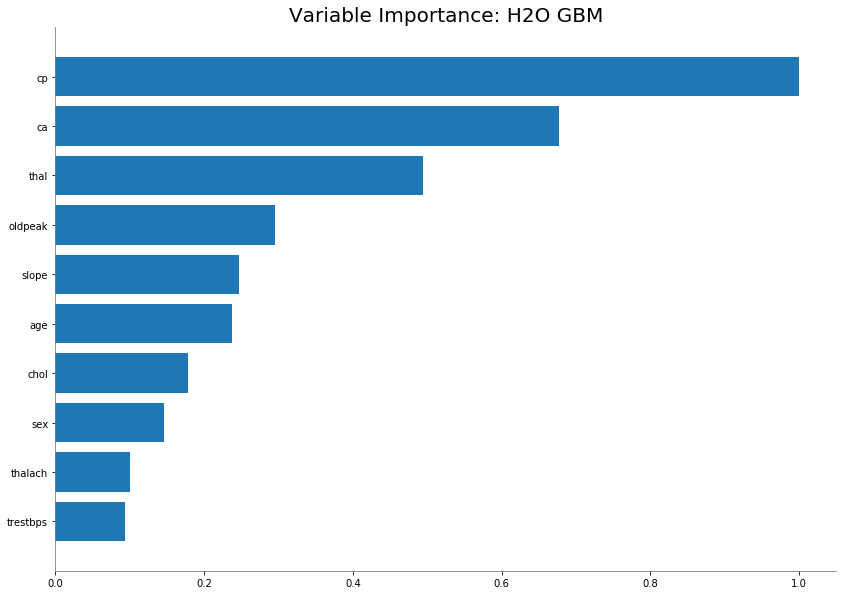

In [138]:
gbm_model.varimp_plot()

In [139]:
gbm_model.scoring_history().head()

,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
0,,2018-11-02 12:11:13,0.002 sec,0.0,0.499222,0.691592,0.500000,1.00000,0.527881,0.492521,0.678287,0.500000,1.000000,0.647059
1,,2018-11-02 12:11:13,0.263 sec,10.0,0.307965,0.349927,0.981036,2.11811,0.074349,0.430755,0.550329,0.784091,2.833333,0.264706
2,,2018-11-02 12:11:14,0.394 sec,20.0,0.232779,0.225208,0.992958,2.11811,0.029740,0.414652,0.522635,0.803030,2.833333,0.264706
3,,2018-11-02 12:11:14,0.509 sec,30.0,0.180701,0.153770,0.998336,2.11811,0.014870,0.395491,0.515409,0.829545,2.833333,0.205882
4,,2018-11-02 12:11:14,0.603 sec,40.0,0.140463,0.109392,0.999945,2.11811,0.003717,0.384039,0.519044,0.848485,2.833333,0.117647


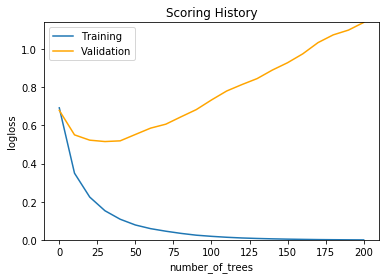

In [140]:
gbm_model.plot()

In [141]:
predictions_df, mod_perf = predictions_test(gbm_model,test_3)
predictions_df.head(5)

gbm prediction progress: |████████████████████████████████████████████████| 100%


predict,p0,p1
0,0.981615,0.0183855
0,0.995821,0.00417919
0,0.999952,4.77026e-05
1,0.114285,0.885715
0,0.996439,0.00356113


In [142]:
actual_value = [test_3[x, 'num'] for x in range(len(test_3['num']))]

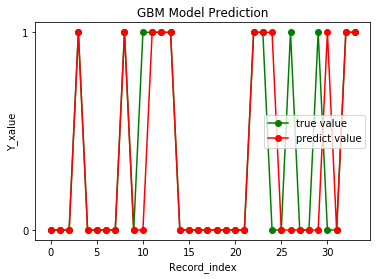

In [143]:
pred_value = [predictions_df[x,0] for x in range(len(predictions_df[0]))]
plot_result('GBM Model Prediction', pred_value, actual_value)

In [155]:
gain_table = gbm_model.gains_lift().as_data_frame()

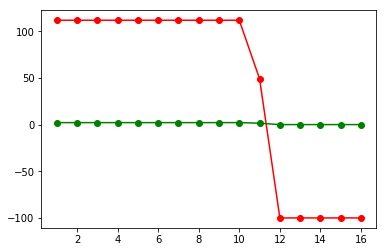

In [169]:
plt.figure()
plt.plot(gain_table['group'],gain_table['gain'],'ro-',label='Gain')
plt.plot(gain_table['group'],gain_table['lift'],'go-',label='Lift')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [168]:
list(gain_table['group'])[::-1]

[16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

##### DRF Model

In [170]:
drf_model = H2ORandomForestEstimator(model_id = 'rf_model', max_depth=50, ntrees=200)
drf_model.train(x = X, y = y, training_frame = train_3, validation_frame = test_3)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [171]:
drf_model.model_performance()


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.12154661158113446
RMSE: 0.34863535618341185
LogLoss: 0.37652420579838564
Mean Per-Class Error: 0.1643007652212487
AUC: 0.9103360319396695
Gini: 0.820672063879339
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4338235294117647: 


,0,1,Error,Rate
0,116.0,26.0,0.1831,(26.0/142.0)
1,20.0,107.0,0.1575,(20.0/127.0)
Total,136.0,133.0,0.171,(46.0/269.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4338235,0.8230769,122.0
max f2,0.1712329,0.8831909,181.0
max f0point5,0.5774648,0.8586762,98.0
max accuracy,0.5774648,0.8401487,98.0
max precision,1.0,1.0,0.0
max recall,0.0985915,1.0,209.0
max specificity,1.0,1.0,0.0
max absolute_mcc,0.5774648,0.6837567,98.0
max min_per_class_accuracy,0.4677419,0.8267717,118.0
max mean_per_class_accuracy,0.5774648,0.8356992,98.0


Gains/Lift Table: Avg response rate: 47.21 %, avg score: 47.33 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0111524,0.9995886,2.1181102,2.1181102,1.0,1.0,1.0,1.0,0.0236220,0.0236220,111.8110236,111.8110236
,2,0.0223048,0.9992895,2.1181102,2.1181102,1.0,0.9993568,1.0,0.9996784,0.0236220,0.0472441,111.8110236,111.8110236
,3,0.0334572,0.9868351,2.1181102,2.1181102,1.0,0.9912408,1.0,0.9968659,0.0236220,0.0708661,111.8110236,111.8110236
,4,0.0408922,0.9856179,2.1181102,2.1181102,1.0,0.9861905,1.0,0.9949249,0.0157480,0.0866142,111.8110236,111.8110236
,5,0.0520446,0.9841218,2.1181102,2.1181102,1.0,0.9850832,1.0,0.9928160,0.0236220,0.1102362,111.8110236,111.8110236
,6,0.1003717,0.9514518,2.1181102,2.1181102,1.0,0.9663631,1.0,0.9800794,0.1023622,0.2125984,111.8110236,111.8110236
,7,0.1524164,0.9090811,2.1181102,2.1181102,1.0,0.9237604,1.0,0.9608485,0.1102362,0.3228346,111.8110236,111.8110236
,8,0.2007435,0.8720635,1.9551787,2.0788860,0.9230769,0.8849356,0.9814815,0.9425732,0.0944882,0.4173228,95.5178680,107.8885973
,9,0.3011152,0.7548387,1.7258676,1.9612132,0.8148148,0.8148307,0.9259259,0.8999923,0.1732283,0.5905512,72.5867600,96.1213182
,10,0.4014870,0.5766777,1.6474191,1.8827647,0.7777778,0.6541994,0.8888889,0.8385441,0.1653543,0.7559055,64.7419073,88.2764654


In [172]:
drf_model.model_performance(test_3)


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.156301672064468
RMSE: 0.3953500626842849
LogLoss: 0.5275139869814742
Mean Per-Class Error: 0.1477272727272727
AUC: 0.8409090909090909
Gini: 0.6818181818181819
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5700000000000001: 


,0,1,Error,Rate
0,21.0,1.0,0.0455,(1.0/22.0)
1,3.0,9.0,0.25,(3.0/12.0)
Total,24.0,10.0,0.1176,(4.0/34.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5700000,0.8181818,9.0
max f2,0.0200000,0.7894737,26.0
max f0point5,0.5700000,0.8653846,9.0
max accuracy,0.5700000,0.8823529,9.0
max precision,0.9947368,1.0,0.0
max recall,0.0200000,1.0,26.0
max specificity,0.9947368,1.0,0.0
max absolute_mcc,0.5700000,0.7389335,9.0
max min_per_class_accuracy,0.5700000,0.75,9.0
max mean_per_class_accuracy,0.5700000,0.8522727,9.0


Gains/Lift Table: Avg response rate: 35.29 %, avg score: 35.98 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0294118,0.9873987,2.8333333,2.8333333,1.0,0.9947368,1.0,0.9947368,0.0833333,0.0833333,183.3333333,183.3333333
,2,0.0294118,0.9800605,0.0,2.8333333,0.0,0.0,1.0,0.9947368,0.0,0.0833333,-100.0,183.3333333
,3,0.0294118,0.9727224,0.0,2.8333333,0.0,0.0,1.0,0.9947368,0.0,0.0833333,-100.0,183.3333333
,4,0.0588235,0.9637000,2.8333333,2.8333333,1.0,0.9725,1.0,0.9836184,0.0833333,0.1666667,183.3333333,183.3333333
,5,0.0588235,0.954625,0.0,2.8333333,0.0,0.0,1.0,0.9836184,0.0,0.1666667,-100.0,183.3333333
,6,0.1176471,0.8224211,1.4166667,2.125,0.5,0.8875,0.75,0.9355592,0.0833333,0.25,41.6666667,112.5
,7,0.1470588,0.7004868,2.8333333,2.2666667,1.0,0.8047368,0.8,0.9093947,0.0833333,0.3333333,183.3333333,126.6666667
,8,0.2058824,0.6692000,2.8333333,2.4285714,1.0,0.6860000,0.8571429,0.8455677,0.1666667,0.5,183.3333333,142.8571429
,9,0.2941176,0.5415000,2.8333333,2.55,1.0,0.6109444,0.9,0.7751807,0.25,0.75,183.3333333,155.0000000
,10,0.4117647,0.4475000,0.0,1.8214286,0.0,0.4959967,0.6428571,0.6954138,0.0,0.75,-100.0,82.1428571


In [173]:
drf_model.varimp()

[('cp', 1677.5916748046875, 1.0, 0.17675147140769767),
 ('ca', 1643.37060546875, 0.9796010734615015, 0.17314593112688054),
 ('thal', 1184.8614501953125, 0.7062871543716138, 0.12483729377153846),
 ('thalach', 807.3379516601562, 0.4812481867818938, 0.08506132512598624),
 ('oldpeak', 767.1898193359375, 0.4573161817968947, 0.08083130803115131),
 ('age', 681.8443603515625, 0.4064423843966356, 0.07183928948455841),
 ('slope', 593.9176635742188, 0.354029930223256, 0.06257531108932504),
 ('exang', 559.1353759765625, 0.33329646562633275, 0.058910640714439445),
 ('trestbps', 539.3825073242188, 0.32152192659576473, 0.05682947361563918),
 ('chol', 537.2489624023438, 0.32025013623466664, 0.05660468279799297),
 ('sex', 248.9124755859375, 0.14837488724120962, 0.026225479639835028),
 ('restecg', 168.54969787597656, 0.1004712293267668, 0.01775843761764626),
 ('fbs', 81.90333557128906, 0.04882197307090511, 0.008629355577309471)]

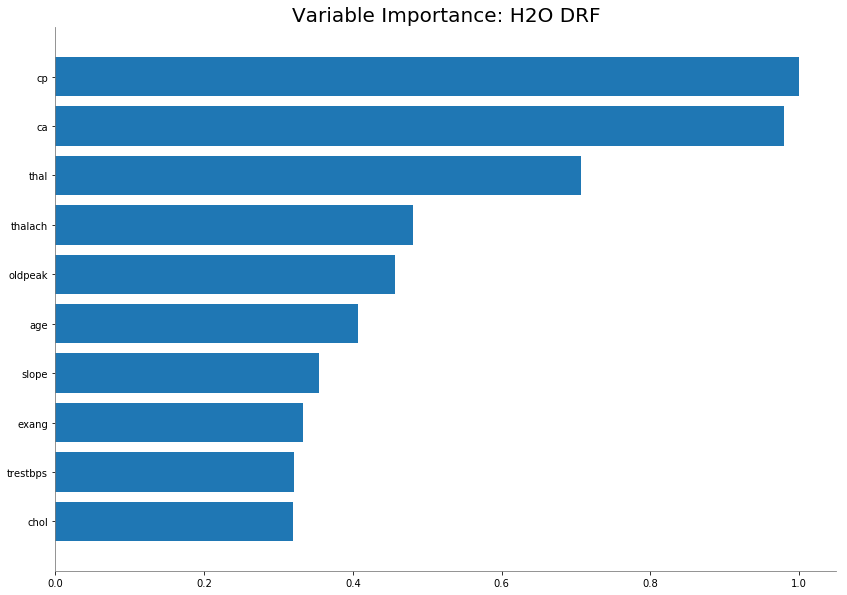

In [174]:
drf_model.varimp_plot()

In [175]:
drf_model.scoring_history().head()

,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
0,,2018-11-02 12:33:21,0.005 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2018-11-02 12:33:21,0.065 sec,1.0,0.483779,8.083543,0.758700,1.616453,0.234043,0.485071,8.126771,0.704545,2.125000,0.235294
2,,2018-11-02 12:33:21,0.089 sec,2.0,0.464660,6.993119,0.783960,1.636722,0.227273,0.469668,6.217398,0.712121,2.361111,0.294118
3,,2018-11-02 12:33:21,0.108 sec,3.0,0.466928,6.804665,0.781512,1.642130,0.229268,0.492592,6.292781,0.662879,1.888889,0.264706
4,,2018-11-02 12:33:21,0.127 sec,4.0,0.460045,6.177832,0.789172,1.594042,0.240343,0.483648,5.332300,0.681818,1.888889,0.264706


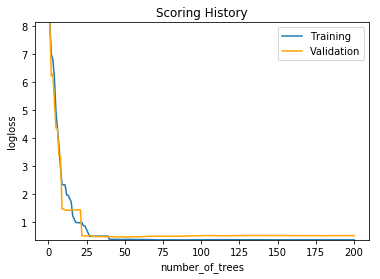

In [176]:
drf_model.plot()

In [177]:
predictions_df, mod_perf = predictions_test(drf_model,test_3)
predictions_df.head(5)

drf prediction progress: |████████████████████████████████████████████████| 100%


predict,p0,p1
0,0.715,0.285
0,0.8365,0.1635
0,0.995,0.005
1,0.43,0.57
0,0.529167,0.470833


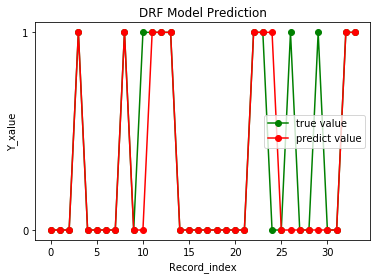

In [178]:
pred_value = [predictions_df[x,0] for x in range(len(predictions_df[0]))]
plot_result('DRF Model Prediction', pred_value, actual_value)

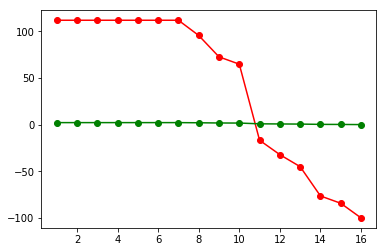

In [181]:
gain_table = drf_model.gains_lift().as_data_frame()

plt.figure()
plt.plot(gain_table['group'],gain_table['gain'],'ro-',label='Gain')
plt.plot(gain_table['group'],gain_table['lift'],'go-',label='Lift')
plt.xlabel('')
plt.ylabel('')
plt.show()

##### Neural Networks Model

In [179]:
nn_model = H2ODeepLearningEstimator(model_id='nn_model',
                                    activation='rectifier_with_dropout',
                                    adaptive_rate=True,
                                    epochs=50,
                                    hidden=[100, 100])
nn_model.train(x = X, y = y, training_frame = train_3, validation_frame = test_3)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [180]:
nn_model.model_performance()


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.08974859400100121
RMSE: 0.2995806969766263
LogLoss: 0.28327636628759245
Mean Per-Class Error: 0.1168348674725519
AUC: 0.95552844626816
Gini: 0.91105689253632
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22897264037375648: 


,0,1,Error,Rate
0,120.0,22.0,0.1549,(22.0/142.0)
1,10.0,117.0,0.0787,(10.0/127.0)
Total,130.0,139.0,0.119,(32.0/269.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2289726,0.8796992,138.0
max f2,0.1055145,0.9226190,163.0
max f0point5,0.6784386,0.9001957,95.0
max accuracy,0.4472695,0.8847584,115.0
max precision,0.9992392,1.0,0.0
max recall,0.0209077,1.0,203.0
max specificity,0.9992392,1.0,0.0
max absolute_mcc,0.4472695,0.7703561,115.0
max min_per_class_accuracy,0.3012097,0.8802817,128.0
max mean_per_class_accuracy,0.2289726,0.8831651,138.0


Gains/Lift Table: Avg response rate: 47.21 %, avg score: 42.87 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0111524,0.9989134,2.1181102,2.1181102,1.0,0.9991331,1.0,0.9991331,0.0236220,0.0236220,111.8110236,111.8110236
,2,0.0223048,0.9986166,2.1181102,2.1181102,1.0,0.9987552,1.0,0.9989442,0.0236220,0.0472441,111.8110236,111.8110236
,3,0.0334572,0.9980478,2.1181102,2.1181102,1.0,0.9982957,1.0,0.9987280,0.0236220,0.0708661,111.8110236,111.8110236
,4,0.0408922,0.9975211,2.1181102,2.1181102,1.0,0.9978099,1.0,0.9985611,0.0157480,0.0866142,111.8110236,111.8110236
,5,0.0520446,0.9968390,2.1181102,2.1181102,1.0,0.9971235,1.0,0.9982530,0.0236220,0.1102362,111.8110236,111.8110236
,6,0.1003717,0.9914087,2.1181102,2.1181102,1.0,0.9952477,1.0,0.9968060,0.1023622,0.2125984,111.8110236,111.8110236
,7,0.1524164,0.9830609,2.1181102,2.1181102,1.0,0.9869411,1.0,0.9934375,0.1102362,0.3228346,111.8110236,111.8110236
,8,0.2007435,0.9690854,1.9551787,2.0788860,0.9230769,0.9751984,0.9814815,0.9890466,0.0944882,0.4173228,95.5178680,107.8885973
,9,0.3011152,0.8725410,2.0396617,2.0658112,0.9629630,0.9305632,0.9753086,0.9695522,0.2047244,0.6220472,103.9661709,106.5811218
,10,0.4014870,0.5562231,1.6474191,1.9612132,0.7777778,0.7114397,0.9259259,0.9050240,0.1653543,0.7874016,64.7419073,96.1213182


In [93]:
nn_model.model_performance(test_3)


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.11144971076172869
RMSE: 0.33384084645490686
LogLoss: 0.4068389717922541
Mean Per-Class Error: 0.08333333333333326
AUC: 0.9074074074074073
Gini: 0.8148148148148147
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46193920170941855: 


,0,1,Error,Rate
0,18.0,0.0,0.0,(0.0/18.0)
1,2.0,10.0,0.1667,(2.0/12.0)
Total,20.0,10.0,0.0667,(2.0/30.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4619392,0.9090909,9.0
max f2,0.4619392,0.8620690,9.0
max f0point5,0.4619392,0.9615385,9.0
max accuracy,0.4619392,0.9333333,9.0
max precision,0.9795837,1.0,0.0
max recall,0.0214495,1.0,22.0
max specificity,0.9795837,1.0,0.0
max absolute_mcc,0.4619392,0.8660254,9.0
max min_per_class_accuracy,0.4619392,0.8333333,9.0
max mean_per_class_accuracy,0.4619392,0.9166667,9.0


Gains/Lift Table: Avg response rate: 40.00 %, avg score: 31.14 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0333333,0.9655308,2.5,2.5,1.0,0.9795837,1.0,0.9795837,0.0833333,0.0833333,150.0,150.0
,2,0.0333333,0.9514779,0.0,2.5,0.0,0.0,1.0,0.9795837,0.0,0.0833333,-100.0,150.0
,3,0.0333333,0.9374250,0.0,2.5,0.0,0.0,1.0,0.9795837,0.0,0.0833333,-100.0,150.0
,4,0.0666667,0.9250487,2.5,2.5,1.0,0.9311254,1.0,0.9553545,0.0833333,0.1666667,150.0,150.0
,5,0.0666667,0.9140346,0.0,2.5,0.0,0.0,1.0,0.9553545,0.0,0.1666667,-100.0,150.0
,6,0.1,0.8830815,2.5,2.5,1.0,0.8931457,1.0,0.9346183,0.0833333,0.25,150.0,150.0
,7,0.1666667,0.7942886,2.5,2.5,1.0,0.8566547,1.0,0.9034328,0.1666667,0.4166667,150.0,150.0
,8,0.2,0.6352200,2.5,2.5,1.0,0.7254675,1.0,0.8737719,0.0833333,0.5,150.0,150.0
,9,0.3,0.4661637,2.5,2.5,1.0,0.5480500,1.0,0.7651980,0.25,0.75,150.0,150.0
,10,0.4,0.2371131,0.8333333,2.0833333,0.3333333,0.4065474,0.8333333,0.6755353,0.0833333,0.8333333,-16.6666667,108.3333333


In [94]:
nn_model.varimp()

[('ca', 1.0, 1.0, 0.046285277962165645),
 ('cp.4', 0.9893800616264343, 0.9893800616264343, 0.045793731162604094),
 ('sex.1', 0.9012927412986755, 0.9012927412986755, 0.04171658505629145),
 ('slope.3', 0.8718557953834534, 0.8718557953834534, 0.040354087832248156),
 ('oldpeak', 0.8623756170272827, 0.8623756170272827, 0.03991529514190189),
 ('thal.3', 0.8590776920318604, 0.8590776920318604, 0.03976264976679039),
 ('fbs.0', 0.8567758798599243, 0.8567758798599243, 0.039656109750595636),
 ('fbs.1', 0.8434954285621643, 0.8434954285621643, 0.03904142037081581),
 ('sex.0', 0.837813138961792, 0.837813138961792, 0.03877841401720106),
 ('exang.0', 0.8338671922683716, 0.8338671922683716, 0.038595774777672204),
 ('thal.6', 0.8319171071052551, 0.8319171071052551, 0.038505514543847465),
 ('restecg.1', 0.8271257281303406, 0.8271257281303406, 0.038283744236171466),
 ('cp.1', 0.8239781856536865, 0.8239781856536865, 0.03813805935774181),
 ('trestbps', 0.8237975239753723, 0.8237975239753723, 0.0381296973817

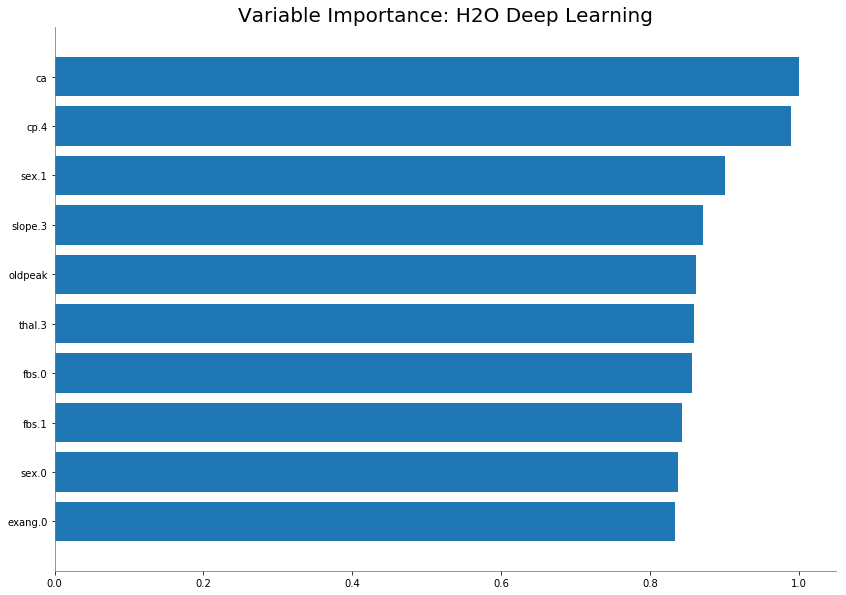

In [95]:
nn_model.varimp_plot()

In [96]:
nn_model.scoring_history()

,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_auc,validation_lift,validation_classification_error
0,,2018-11-02 11:56:38,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2018-11-02 11:56:38,0.082 sec,25754 obs/sec,5.0,1,1365.0,0.393146,0.570975,0.378737,0.925682,2.149606,0.135531,0.395762,0.601699,0.347384,0.907407,2.5,0.100000
2,,2018-11-02 11:56:39,0.446 sec,33870 obs/sec,50.0,10,13650.0,0.321985,0.327489,0.583285,0.950221,2.149606,0.117216,0.333841,0.406839,0.535626,0.907407,2.5,0.066667


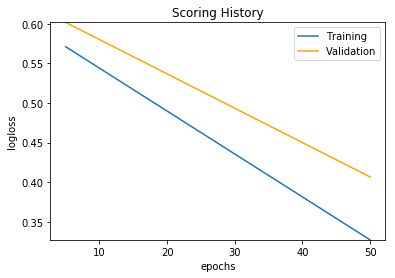

In [97]:
nn_model.plot()

In [98]:
predictions_df, mod_perf = predictions_test(nn_model,test_3)
predictions_df.head(5)

deeplearning prediction progress: |███████████████████████████████████████| 100%


predict,p0,p1
1,0.106854,0.893146
0,0.973457,0.0265434
0,0.908845,0.0911549
1,0.274533,0.725467
0,0.831189,0.168811


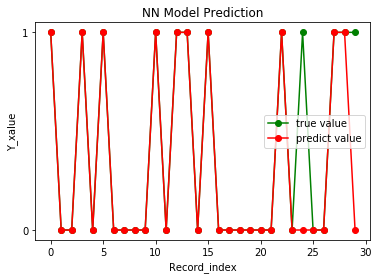

In [99]:
pred_value = [predictions_df[x,0] for x in range(len(predictions_df[0]))]
plot_result('NN Model Prediction', pred_value, actual_value)